<h1>BrainNetCNN Synthetic Experiments</h1>
<p>Version 1.0 <br />
Software by <a href='http://kawahara.ca/about/'>Jeremy Kawahara</a> and <a href='http://www.sfu.ca/~cjbrown/'>Colin J Brown</a><br />
<a href='http://mial.sfu.ca/'>Medical Image Analysis Lab</a>, Simon Fraser University, Canada, 2017<br />
Implements method and synthetic experiments described in: <a href='dx.doi.org/10.1016/j.neuroimage.2016.09.046'>dx.doi.org/10.1016/j.neuroimage.2016.09.046</a><br />
</p>

In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
# sys.path.insert(0, os.path.join('/home/jer/projects/caffe/', 'python')) # If you don't have pycaffe in path.
import caffe
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..'))) # To import ann4brains if not installed.
from ann4brains.synthetic.injury import ConnectomeInjury
from ann4brains.nets import BrainNetCNN

<h1>Generate synthetic data</h1>

In [3]:
# Number of outputs.
n_injuries = 2 # NOTE: The synthetic code only works for 2 injuries right now.

n_samples = 100  # Number of training/testing samples.
noise_weight = 0.125  # How much to weigh the noise.

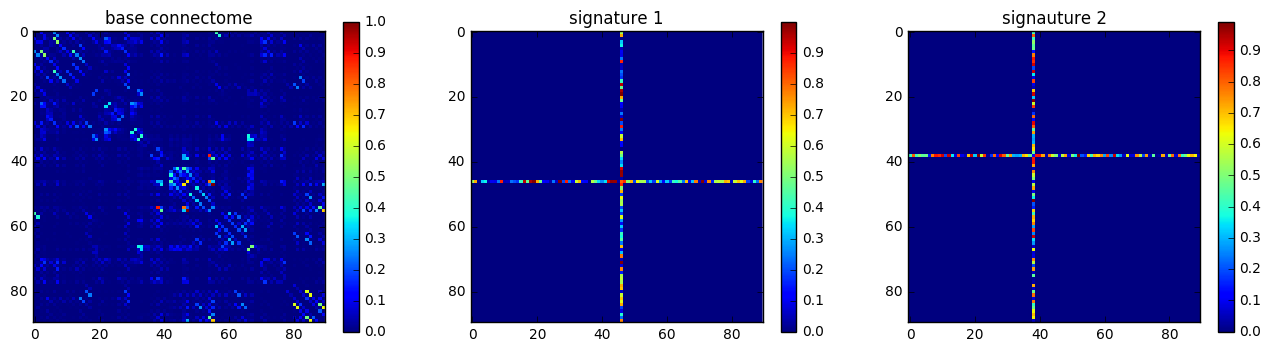

In [4]:
# Object to create synthetic injury data.
injury = ConnectomeInjury(base_filename=os.path.join('data', 'base.mat'), # Where the base matrix is.
                          n_injuries=n_injuries, # Only works for 2 injuries right now.
                          signature_seed=333, # Set the seed so we generate the same signatures.
                         ) 

# View the realistic base connectome and the injury signatures.
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); plt.imshow(injury.X_mn, interpolation="None"); plt.colorbar(); plt.title('base connectome')
plt.subplot(1,3,2); plt.imshow(injury.sigs[0], interpolation="None"); plt.colorbar(); plt.title('signature 1')
plt.subplot(1,3,3); plt.imshow(injury.sigs[1], interpolation="None"); plt.colorbar(); plt.title('signauture 2')

In [5]:
# Generate train, validate, and test data
np.random.seed(seed=333) # To reproduce results.
x_train, y_train = injury.generate_injury(n_samples=112, noise_weight=0.125)
x_test, y_test = injury.generate_injury(n_samples=56, noise_weight=0.125)
x_valid, y_valid = injury.generate_injury(n_samples=56, noise_weight=0.125)

In [6]:
print(x_train.shape) # 112 samples of size 90 x 90 (1 since there's only 1 channel)
print(y_train.shape) # How much each of the 2 signatures weight the 112 samples.

(112, 1, 90, 90)
(112, 2)


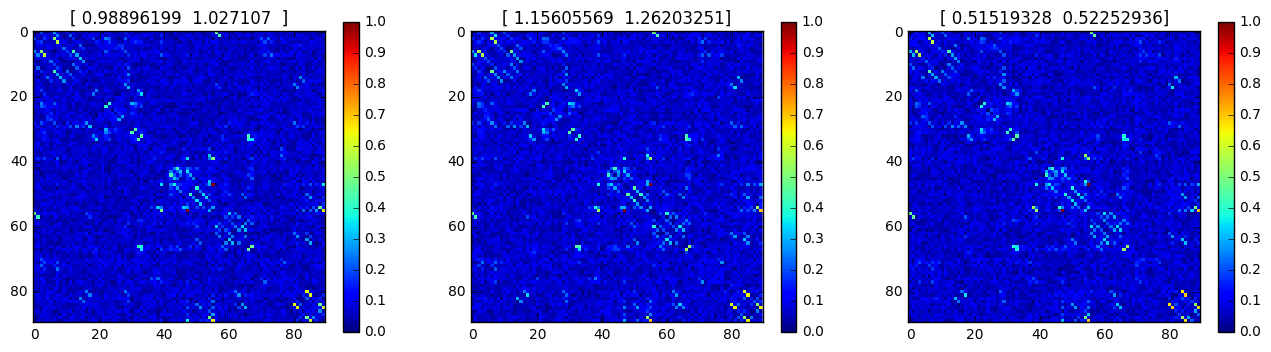

In [7]:
# Show example noisy training data that have the signatures applied.
# It's not obvious to the human eye the subtle differences, but the cross row and column above 
# perturbed the below matrices with the y weights.
plt.figure(figsize=(16,4))
for idx in range(3):
    plt.subplot(1,3,idx+1); plt.imshow(np.squeeze(x_train[idx]), interpolation="None"); plt.colorbar();
    plt.title(y_train[idx]) # How much each signature is weighted by.

In [8]:
# Spatial height and width of the data. 
h = x_train.shape[2]
w = x_train.shape[3]
print(h, w)

90 90


<h1>Edge-to-Node test</h1>
<p>Example of using the Edge-to-Node (E2N) layer.</p>

In [50]:
# Unique name for the model
net_name = 'E2Nnet_sml'

# Specify the architecture using a list of dictionaries.
e2n_arch = [
    ['e2n', # e2n layer 
     {'n_output': 130, # 130 feature maps 
      'kernel_h': h, 'kernel_w': w  # Cross filter of size h x 1 by 1 x w (non-sliding, only on diagonal)
     }
    ], 
    ['dropout', {'dropout_ratio': 0.5}], # Dropout with 0.5 dropout rate.
    ['relu',    {'negative_slope': 0.33}], # Very leaky ReLU.
    ['fc',      {'n_output': 30}],  # Fully connected/dense (or a Node-to-Graph when applied after e2n) layer
    ['relu',    {'negative_slope': 0.33}], # Very leaky ReLU
    ['out',     {'n_output': n_injuries}] # Output layer with two nodes that correspond to the two injuries.
]

# Create BrainNetCNN model
E2Nnet_sml = BrainNetCNN(net_name, # Unique model name.
                         e2n_arch, # List of dictionaries specifying the architecture.
                         hardware='gpu', # Or 'cpu'.
                         dir_data='./generated_synthetic_data', # Where to write the data to.
                        )

In [51]:
# Overwrite default parameters.
# Look at ann4brains.nets.get_default_hyper_params() for all the hyper-parameters and what can be overwritten.
E2Nnet_sml.pars['max_iter'] = 100000 # Train the model for 100K iterations.
E2Nnet_sml.pars['test_interval'] = 500 # Check the valid data every 500 iterations.
E2Nnet_sml.pars['snapshot'] = 10000 # Save the model weights every 10000 iterations.

In [52]:
# Train (optimize) the network.
E2Nnet_sml.fit(x_train, y_train, x_valid, y_valid)  # If no valid data, you could put test data here to monitor.

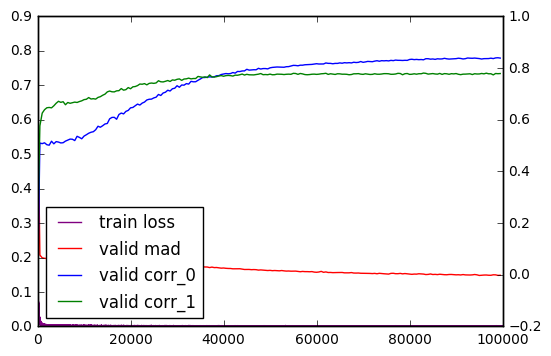

In [56]:
# Plot the training iterations vs. the training loss, the valid data mean-absolute-difference, 
# and the valid data correlation with predicted and true (y_vald) labels.
E2Nnet_sml.plot_iter_metrics() 

In [54]:
# Predict labels of test data
preds = E2Nnet_sml.predict(x_test)

In [55]:
# Compute the metrics.
E2Nnet_sml.print_results(preds, y_test)

E2E prediction results
class 0 => mae: 0.165, SDAE: 0.098, corr: 0.755, p-val: 0.000
class 1 => mae: 0.161, SDAE: 0.108, corr: 0.749, p-val: 0.000


<h1>Edge-to-Edge test</h1>
<p>Example of using the Edge-to-Edge (E2E) layer along with an E2N layer.</p>

In [9]:
# Unique name for the model
net_name = 'E2Enet_sml'

# Specify the architecture.
e2e_arch = [
    ['e2e', # e2e layer 
     {'n_output': 32, # 32 feature maps 
      'kernel_h': h, 'kernel_w': w  # Sliding cross filter of size h x 1 by 1 x w
     }
    ], 
    ['e2n', {'n_output': 64, 'kernel_h': h, 'kernel_w': w}],
    ['dropout', {'dropout_ratio': 0.5}],
    ['relu',    {'negative_slope': 0.33}],
    ['fc',      {'n_output': 30}],
    ['relu',    {'negative_slope': 0.33}],
    ['out',     {'n_output': n_injuries}] 
]

# Create BrainNetCNN model
E2Enet_sml = BrainNetCNN(net_name, e2e_arch, 
                         hardware='gpu', # Or 'cpu'.
                         dir_data='./generated_synthetic_data', # Where to write the data to.
                        )

In [13]:
# Overwrite default parameters.
# Look at ann4brains.nets.get_default_hyper_params() for all the hyper-parameters and what can be overwritten.
E2Enet_sml.pars['max_iter'] = 100 # Train the model for 100K iterations.
E2Enet_sml.pars['test_interval'] = 10 # Check the valid data every 500 iterations.
E2Enet_sml.pars['snapshot'] = 100 # Save the model weights every 10000 iterations.

In [14]:
# Train (optimize) the network.
E2Enet_sml.fit(x_train, y_train, x_valid, y_valid)  # If no valid data, you could put test data here to monitor.

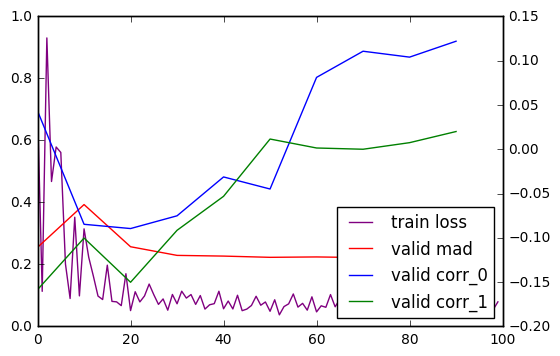

In [15]:
# Visualize the training loss, and valid metrics over training iterations.
E2Enet_sml.plot_iter_metrics() 

In [16]:
# Predict labels of test data
preds = E2Enet_sml.predict(x_test)

In [17]:
# Compute the metrics.
E2Enet_sml.print_results(preds, y_test)

E2E prediction results
class 0 => mae: 0.231, SDAE: 0.133, corr: 0.007, p-val: 0.959
class 1 => mae: 0.230, SDAE: 0.123, corr: 0.339, p-val: 0.011
